In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Importing machine learning modules
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Setting seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Importing necessary libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Downloading NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# Downloading NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Reading the IMDb dataset
imdb_data_df = pd.read_csv('IMDB Dataset.csv')

# Setting display options for DataFrame
pd.set_option('display.max_colwidth', 100)
imdb_data_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive
...,...,...
49995,"I thought this movie did a down right good job. It wasn't as creative or original as the first, ...",positive
49996,"Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ...",negative
49997,"I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests in high...",negative
49998,I'm going to have to disagree with the previous comment and side with Maltin on this one. This i...,negative


In [3]:
imdb_data_df['sentiment'] = imdb_data_df['sentiment'].map({'negative': 0, 'positive': 1})

def preprocess_text(text):
   # Convert to lowercase
   text = text.lower()

   # Remove hashtags and Twitter handles
   text = re.sub(r'#|@\S+', '', text)

   # Remove HTML tags
   text = re.sub(r'<[^>]+>', '', text)

   # Remove line breaks
   text = re.sub(r'\n', ' ', text)

   # Remove special characters and punctuation
   text = re.sub(r'[^\w\s]', '', text)

   # Remove URLs
   text = re.sub(r'https?://\S+', '', text)

   # Tokenize the text
   tokens = word_tokenize(text)

   # Remove stop words except 'over'
   stop_words = set(stopwords.words('english'))
   stop_words.remove('over')
   tokens = [word for word in tokens if word not in stop_words]

   # Join the tokens back into a single string
   return ' '.join(tokens)

imdb_data_df['review'] = imdb_data_df['review'].apply(preprocess_text)

In [5]:
# Define lists of positive and negative words
positive_words = ['excellent', 'amazing', 'outstanding', 'fantastic', 'brilliant', 'good',
                 'superb', 'terrific', 'masterpiece', 'incredible', 'phenomenal', 'great']

negative_words = ['terrible', 'awful', 'horrible', 'disappointing', 'boring',
                 'mediocre', 'trash', 'disgusting', 'unbearable', 'dreadful', 'bad']

# Create a feature based on positive and negative words
feature_df = (imdb_data_df['review'].str.contains('|'.join(positive_words), case=False) &
             ~imdb_data_df['review'].str.contains('|'.join(negative_words), case=False))

feature_df = feature_df.replace({False: 0, True: 1})
feature_df

imdb_data_df['One Hot Encoded'] = feature_df
imdb_data_df

,review,sentiment,One Hot Encoded
0,one reviewers mentioned watching 1 oz episode youll hooked right exactly happened methe first th...,1,0
1,wonderful little production filming technique unassuming oldtimebbc fashion gives comforting som...,1,1
2,thought wonderful way spend time hot summer weekend sitting air conditioned theater watching lig...,1,1
3,basically theres family little boy jake thinks theres zombie closet parents fighting timethis mo...,0,0
4,petter matteis love time money visually stunning film watch mr mattei offers us vivid portrait h...,1,1
...,...,...,...
49995,thought movie right good job wasnt creative original first expecting whole lotta fun think like ...,1,0
49996,bad plot bad dialogue bad acting idiotic directing annoying porn groove soundtrack ran continual...,0,0
49997,catholic taught parochial elementary schools nuns taught jesuit priests high school college stil...,0,0
49998,im going disagree previous comment side maltin one second rate excessively vicious western creak...,0,0


In [6]:
df_train, df_test = train_test_split(imdb_data_df, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_preprocessed = vectorizer.fit_transform(df_train['review'])
X_processed = np.hstack((X_preprocessed.toarray(), df_train['One Hot Encoded'].to_numpy().reshape(len(df_train), 1)))

X_train = X_processed
y_train = df_train['sentiment'].to_numpy()


In [9]:
# accuracy, precision, recall, F-1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# C_values = [3.5, 3.6, 3.7, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.7]
C_values = np.linspace(3.5, 4.7, 5)  # Changed to create linearly spaced values

param_grid = {
   'n_estimators': [3, 5, 7],
   'max_depth': [13, 15],
   'max_leaf_nodes': [22, 24],
}

accuracies_lr = []
precision_lr = []
recall_lr = []
f1score_lr = []

accuracies_rf = []
precision_rf = []
recall_rf = []
f1score_rf = []

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=13, max_leaf_nodes=24, n_estimators=7)


In [10]:
for C_val in C_values:
   kf_accuracy = []
   kf_precision = []
   kf_recall = []
   kf_f1score = []

   for train, val in kf.split(X_train):
       X_train_fold, X_val_fold = X_train[train], X_train[val]
       y_train_fold, y_val_fold = y_train[train], y_train[val]

       model = LogisticRegression(C=C_val, max_iter=10000)
       model.fit(X_train_fold, y_train_fold)

       y_pred_fold = model.predict(X_val_fold)

       accuracy_sklearn = accuracy_score(y_val_fold, y_pred_fold)
       precision_sklearn = precision_score(y_val_fold, y_pred_fold)
       recall_sklearn = recall_score(y_val_fold, y_pred_fold)
       f1score_sklearn = f1_score(y_val_fold, y_pred_fold)

       print(f"Accuracy for C={C_val:.2f}: {accuracy_sklearn:.4f}")

       kf_accuracy.append(accuracy_sklearn)
       kf_precision.append(precision_sklearn)
       kf_recall.append(recall_sklearn)
       kf_f1score.append(f1score_sklearn)

   accuracies_lr.append(np.mean(kf_accuracy))
   precision_lr.append(np.mean(kf_precision))
   recall_lr.append(np.mean(kf_recall))
   f1score_lr.append(np.mean(kf_f1score))

print(accuracies_lr)
print(precision_lr)
print(recall_lr)
print(f1score_lr)

Accuracy for C=3.50: 0.8836
Accuracy for C=3.50: 0.8874
Accuracy for C=3.50: 0.8844
Accuracy for C=3.50: 0.8758
Accuracy for C=3.50: 0.8778
Accuracy for C=3.80: 0.8836
Accuracy for C=3.80: 0.8871
Accuracy for C=3.80: 0.8840
Accuracy for C=3.80: 0.8756
Accuracy for C=3.80: 0.8780
Accuracy for C=4.10: 0.8825
Accuracy for C=4.10: 0.8869
Accuracy for C=4.10: 0.8835
Accuracy for C=4.10: 0.8758
Accuracy for C=4.10: 0.8770
Accuracy for C=4.40: 0.8822
Accuracy for C=4.40: 0.8862
Accuracy for C=4.40: 0.8828
Accuracy for C=4.40: 0.8751
Accuracy for C=4.40: 0.8768
Accuracy for C=4.70: 0.8820
Accuracy for C=4.70: 0.8855
Accuracy for C=4.70: 0.8815
Accuracy for C=4.70: 0.8752
Accuracy for C=4.70: 0.8762
[0.881775, 0.8816749999999999, 0.8811249999999999, 0.880625, 0.8801]
[0.8769165140100593, 0.8768568238630738, 0.8763120906233525, 0.876227175953414, 0.875765225882257]
[0.8876797943474932, 0.8875303207266866, 0.8869801183097937, 0.885926452953694, 0.8853287079482703]
[0.8822289535471148, 0.882124839

In [20]:
kf_accuracy = []
kf_precision = []
kf_recall = []
kf_f1score = []
index = 0
for train, val in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train], X_train[val]
    y_train_fold, y_val_fold = y_train[train], y_train[val]

    model_rfc = RandomForestClassifier(**grid_search.best_params_)
    model_rfc.fit(X_train_fold, y_train_fold)
    y_pred_fold = model_rfc.predict(X_val_fold)
    accuracy_sklearn = accuracy_score(y_val_fold, y_pred_fold)
    precision_sklearn = precision_score(y_val_fold, y_pred_fold)
    recall_sklearn = recall_score(y_val_fold, y_pred_fold)
    f1score_sklearn = f1_score(y_val_fold, y_pred_fold)

    print(f"Accuracy for Fold {index}: {accuracy_sklearn:.4f}")
    index += 1

    kf_accuracy.append(accuracy_sklearn)
    kf_precision.append(precision_sklearn)
    kf_recall.append(recall_sklearn)
    kf_f1score.append(f1score_sklearn)

accuracies_rf = np.mean(kf_accuracy)
precision_rf = np.mean(kf_precision)
recall_rf = np.mean(kf_recall)
f1score_rf = np.mean(kf_f1score)

print(f"Random Forest Classifier Metrics:")
print(f"Accuracy: {accuracies_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1score_rf:.4f}")

Accuracy for Fold 0: 0.7676
Accuracy for Fold 1: 0.7632
Accuracy for Fold 2: 0.7829
Accuracy for Fold 3: 0.7668
Accuracy for Fold 4: 0.7541
Random Forest Classifier Metrics:
Accuracy: 0.7669
Precision: 0.7490
Recall: 0.8026
F1-Score: 0.7745


In [21]:
X_test_vectorized = vectorizer.transform(df_test['review'])
X_test = np.hstack((X_test_vectorized.toarray(), df_test['One Hot Encoded'].to_numpy().reshape(len(df_test), 1)))
y_test = df_test['sentiment'].to_numpy()

# Final Solution
model_sklearn = LogisticRegression(C=3.5, max_iter=10000)
model_sklearn.fit(X_train, y_train)

LogisticRegression(C=3.5, max_iter=10000)

In [22]:
# Use the best parameters from the grid search for the Random Forest Classifier
model_rfc = RandomForestClassifier(**grid_search.best_params_)
model_rfc.fit(X_train, y_train)

sklearn_pred = model_sklearn.predict(X_test)
rfc_pred = model_rfc.predict(X_test)

accuracy_sklearn = accuracy_score(y_test, sklearn_pred)
precision_sklearn = precision_score(y_test, sklearn_pred)
recall_sklearn = recall_score(y_test, sklearn_pred)
f1score_sklearn = f1_score(y_test, sklearn_pred)

accuracy_rfc = accuracy_score(y_test, rfc_pred)
precision_rfc = precision_score(y_test, rfc_pred)
recall_rfc = recall_score(y_test, rfc_pred)
f1score_rfc = f1_score(y_test, rfc_pred)

print(f"For the logistic regression model accuracy: {accuracy_sklearn:.4f}, precision: {precision_sklearn:.4f}, recall: {recall_sklearn:.4f}, and f1_score: {f1score_sklearn:.4f}")
print(f"For the random forest classifier model accuracy: {accuracy_rfc:.4f}, precision: {precision_rfc:.4f}, recall: {recall_rfc:.4f}, and f1_score: {f1score_rfc:.4f}")

For the logistic regression model accuracy: 0.8816, precision: 0.8745, recall: 0.8932, and f1_score: 0.8838
For the random forest classifier model accuracy: 0.7833, precision: 0.7623, recall: 0.8281, and f1_score: 0.7939


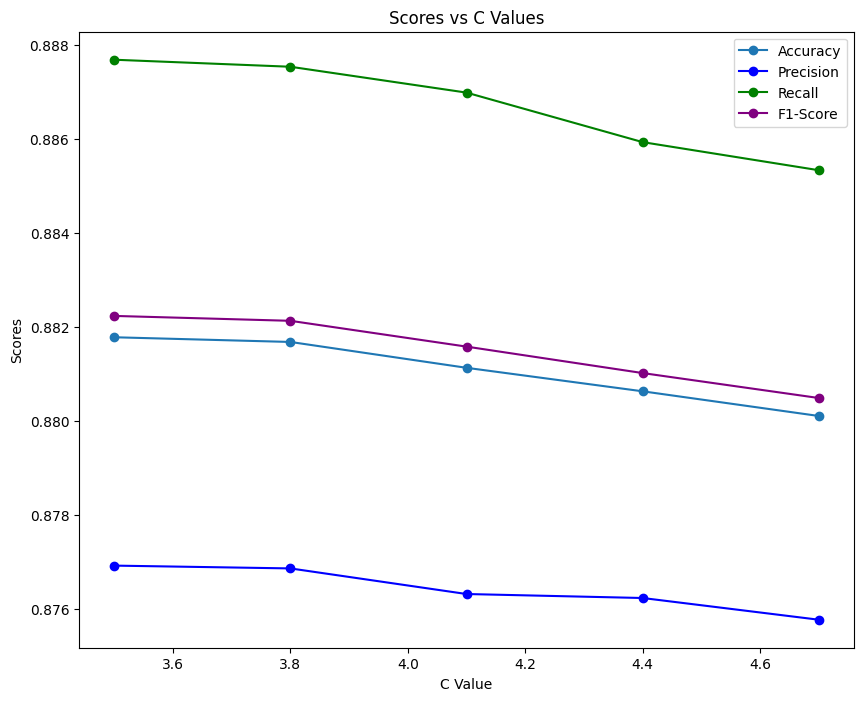

In [27]:
# Create a 2x2 subplot grid
plt.figure(figsize=(10, 8))

# Plot each metric
plt.plot(C_values, accuracies_lr, marker='o', linestyle='-', label='Accuracy')
plt.plot(C_values, precision_lr, marker='o', linestyle='-', color='blue', label='Precision')
plt.plot(C_values, recall_lr, marker='o', linestyle='-', color='green', label='Recall')
plt.plot(C_values, f1score_lr, marker='o', linestyle='-', color='purple', label='F1-Score')

plt.title('Scores vs C Values')
plt.xlabel('C Value')
plt.ylabel('Scores')
plt.legend()

# Show the plot
plt.show()

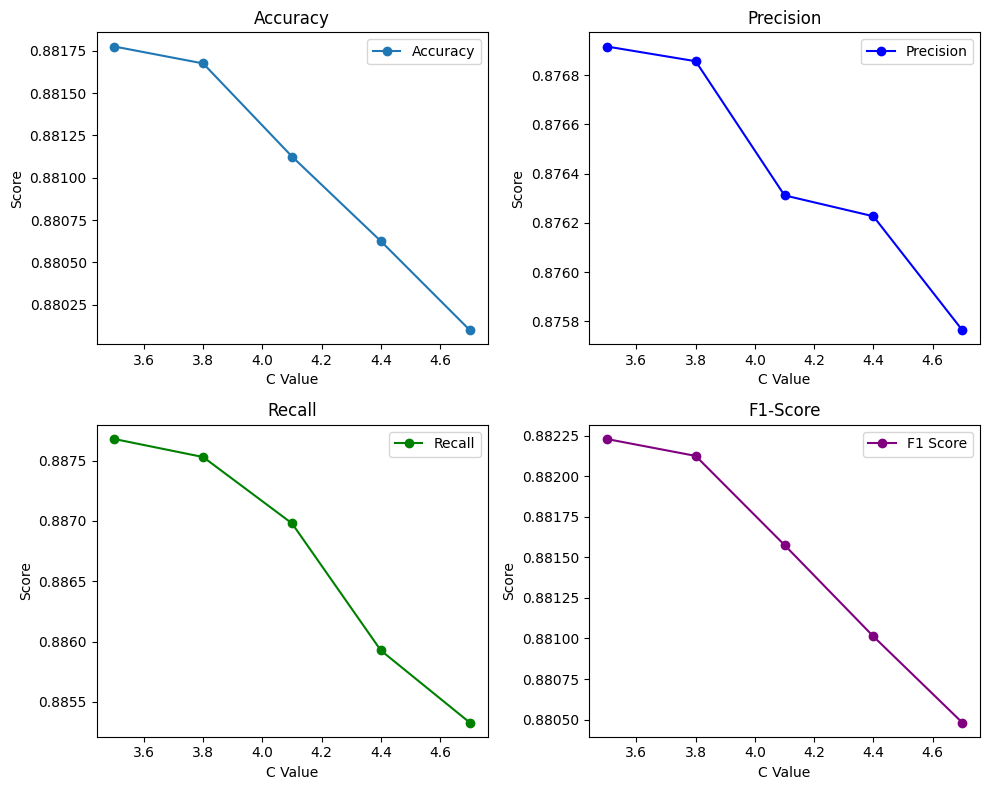

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].set_title('Accuracy')
axs[0, 1].set_title('Precision')
axs[1, 0].set_title('Recall')
axs[1, 1].set_title('F1-Score')

axs[0, 0].plot(C_values, accuracies_lr, marker='o')
axs[0, 1].plot(C_values, precision_lr, marker='o', color='blue')
axs[1, 0].plot(C_values, recall_lr, marker='o', color='green')
axs[1, 1].plot(C_values, f1score_lr, marker='o', color='purple')

for ax in axs.flat:
   ax.set(xlabel='C Value', ylabel='Score')

axs[0, 0].legend(['Accuracy'])
axs[0, 1].legend(['Precision'])
axs[1, 0].legend(['Recall'])
axs[1, 1].legend(['F1 Score'])
plt.tight_layout()
plt.show()

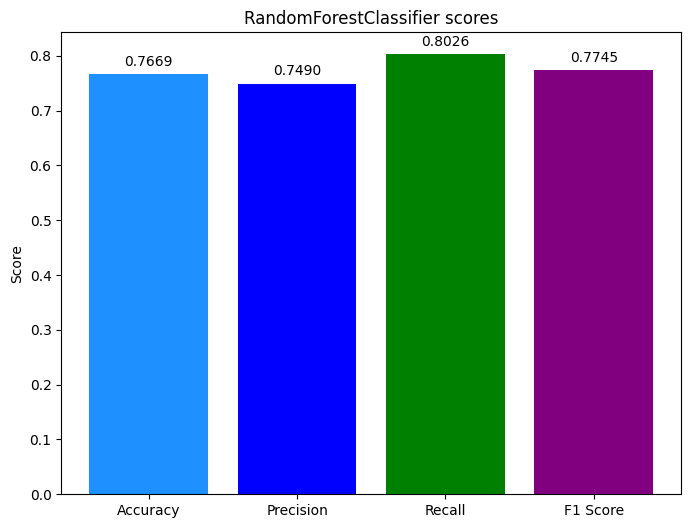

In [32]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracies_rf, precision_rf, recall_rf, f1score_rf]
colors = ['dodgerblue', 'blue', 'green', 'purple']

plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=colors)

plt.title('RandomForestClassifier scores')
plt.ylabel('Score')

# Adding text annotations
for i, score in enumerate(scores):
   plt.text(i, score + 0.015, f'{score:.4f}', ha='center')

plt.show()

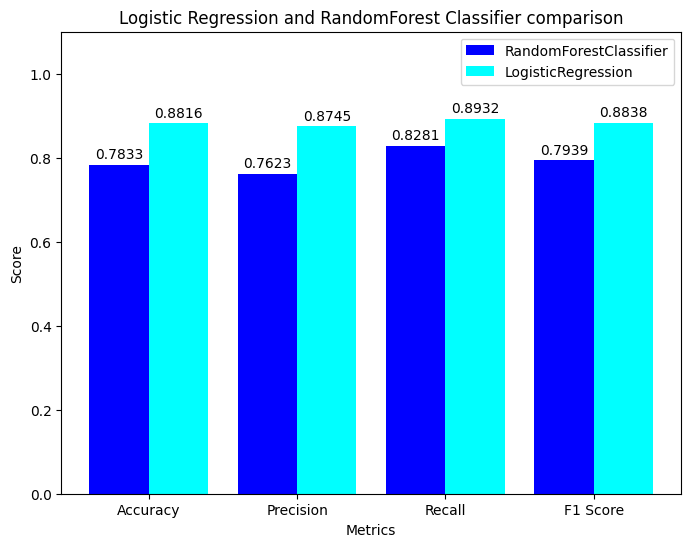

In [30]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))
bar_width = 0.4

plt.figure(figsize=(8, 6))

plt.bar(x - bar_width/2, [accuracy_rfc, precision_rfc, recall_rfc, f1score_rfc], width=bar_width, color=['blue'], label='RandomForestClassifier')
plt.bar(x + bar_width/2, [accuracy_sklearn, precision_sklearn, recall_sklearn, f1score_sklearn], width=bar_width, color=['cyan'], label='LogisticRegression')

plt.xticks(x, metrics)

plt.title('Logistic Regression and RandomForest Classifier comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')

for i, score in enumerate([accuracy_rfc, precision_rfc, recall_rfc, f1score_rfc]):
   plt.text(x[i] - bar_width/2, score + 0.015, f'{score:.4f}', ha='center')

for i, score in enumerate([accuracy_sklearn, precision_sklearn, recall_sklearn, f1score_sklearn]):
   plt.text(x[i] + bar_width/2, score + 0.015, f'{score:.4f}', ha='center')

plt.legend()

# Increase the y-axis limits to make the scale bigger
plt.ylim(0, 1.1)

plt.show()